## Lambda Demo notebook
This is a small notebook anyone can use to quickly setup Tuplex on Lambda.

In [1]:
import tuplex

Welcome to

  _____            _
 |_   _|   _ _ __ | | _____  __
   | || | | | '_ \| |/ _ \ \/ /
   | || |_| | |_) | |  __/>  <
   |_| \__,_| .__/|_|\___/_/\_\ 0.3.1
            |_|
    
using Python 3.9.7 (default, Sep  3 2021, 12:45:31) 
[Clang 12.0.0 (clang-1200.0.32.29)] on darwin


**TODOs left:**
    
    - Top-level setup.py should build/package Lambda as zip in pip package for easy upload.
    - Script should autodetect location
    - Need to compile/ship full python (because of embedding) with lambda

`tuplex.distributed` provides a convenience function `setup_aws`, that allows to setup everything at once. You can customize it to your setup or just run it with auto-detected defaults. Some defaults are the result of functions, e.g. the default S3 scratch dir, which you can import to retrieve the value.

In [2]:
from tuplex.distributed import setup_aws, default_scratch_dir

Another option to quickly get an overview of all parameters is to simply invoke Python's builtin help

In [3]:
help(setup_aws)

Help on function setup_aws in module tuplex.distributed:

setup_aws(aws_access_key=None, aws_secret_key=None, overwrite=True, iam_user='leonhard', lambda_name='tuplex-lambda-runner', lambda_role='tuplex-lambda-role', lambda_file=None, region='us-east-1', s3_scratch_uri='tuplex-leonhard/scratch', quiet=False)



Let's do the default setup by deploying a Lambda runner. Depending on your network speed, this may take ~30s.

In [4]:
!ls build-lambda/

CMakeCache.txt      build.ninja         googletest-src      test
CMakeFiles          cmake_install.cmake io                  third_party
CTestTestfile.cmake codegen             lam                 utils
adapters            core                lam.zip
awslambda           dist                python
bin                 googletest-build    runtime


In [5]:
setup_aws(lambda_file='build-lambda/lam.zip')

build-lambda/lam.zip  58.2MiB / 58.2MiB  (100.00%)
Completed lambda setup in 22.92s


In [6]:
# setup_aws(lambda_file='tplxlam.zip')

To create a context using the Lambda backend you can either use `tuplex.Context(backend='lambda')` or simply use the `LambdaContext` function provided.

In [9]:
# There's currently a bug in the Lambda backend when transferring local data to S3: The full partition gets transferred, 
# not just what is needed.
c = tuplex.LambdaContext()

Tuplex WebUI can be accessed under http://localhost:5000


We can now simply execute a query in the Lambda environment incl. using some local data that gets automatically shipped to the cloud.

In [10]:
c.parallelize([1, 2, 3, 4, 5]).map(lambda x: x * x).collect()

[1, 4, 9, 16, 25]

In [11]:
# use python fallback mode on Lambda -> standard library

In [12]:
import json

In [22]:
def fallback_f(x):
    d = json.loads(x)
    return d

In [25]:
fallback_f('{"data":100, "bla": 42}')

{'data': 100, 'bla': 42}

In [23]:
c.parallelize(['{"data":100, "bla": 42}']).map(fallback_f).collect()

KeyboardInterrupt: 

[]

In [16]:
import numpy as np

In [17]:
def unsupported_function(x):
    return np.array(x)

In [18]:
c.parallelize([1, 2, 3]).map(unsupported_function).collect()

[]

In [21]:
# TODO: helper function to retrieve Lambda logs?

In [24]:
del c2

In [19]:
c2 = tuplex.Context()

Tuplex WebUI can be accessed under http://localhost:5000


In [20]:
c2.parallelize([1, 2, 3]).map(unsupported_function).collect()

[array(1), array(2), array(3)]

Naturally, more interesting is to access data in the cloud. E.g., let's read a csv file:

In [7]:
c.csv('s3://tuplex-public/test.csv').show()

+----------+
| Column_0 |
+----------+
| 0        |
+----------+
| 1        |
+----------+
| 2        |
+----------+
| 3        |
+----------+
| 4        |
+----------+
| 6        |
+----------+


In [11]:
c.parallelize([1, 2, 3], columns=['column']).tocsv(default_scratch_dir() + "/output.csv")

In [12]:
default_scratch_dir()

'tuplex-leonhard/scratch'

In [16]:
!aws s3 ls "s3://tuplex-leonhard/scratch/output.part0"

2021-11-05 10:09:51    1048576 input_part_0.mem
2021-11-05 10:06:25         56 output.part0


Lambda auto-scales our execution, so let's perform a quick timing experiment:

In [8]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm

In [9]:
N_runs = 10

rows = []

for r in tqdm(range(N_runs)):
    start_time = time.time()
    res = c.parallelize([1, 2, 3, 4, 5]).map(lambda x: x * x).collect()
    duration = time.time() - start_time
    rows.append({'run' : r, 'duration':duration})
df = pd.DataFrame(rows)

100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


(0.0, 2.1519579887390137)

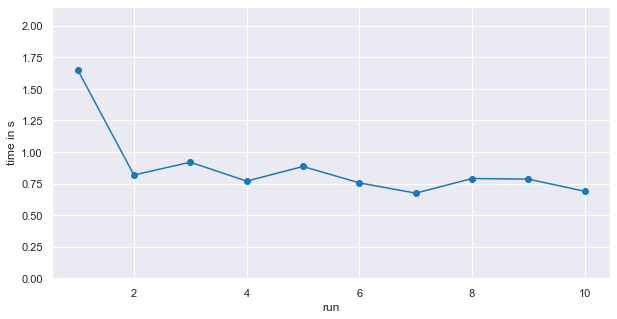

In [10]:
plt.figure(figsize=(10, 5))
sns.set_style('darkgrid')
# sns.set_context('poster')
sns.set_context('notebook')
plt.plot(df['run']+1, df['duration'], marker='o')
plt.xlabel('run')
plt.ylabel('time in s')
plt.ylim(0, df['duration'].max() + 0.5)

As we can see subsequent runs get faster. This is because Lambda reuses containers.

In [ ]:
c.ls('s3://tuplex-public/*')

In [ ]:
c.ls('s3://tuplex-public')

In [ ]:
c.csv('s3://tuplex-public/test.csv').show(5)

In [ ]:
%%time
c.parallelize([1, 2, 3, 4, 5]).map(lambda x: x * x).collect()

In [ ]:
%%file test.csv
A,B,C
1,2,3
4,5,6
7,8,9

In [ ]:
# TODO: recursive as well!
c.cp('test.csv', default_scratch_dir() + '/test.csv')

In [ ]:
c.options()

In [ ]:
import inspect

In [ ]:
%%time

f = lambda x: x

In [ ]:
res = inspect.getsourcefile(f)
print(res)

In [ ]:
f.__code__.co_filename

In [ ]:
f.__code__.co_firstlineno

In [ ]:
inspect.getfile(f), inspect.getclasstree(f)

In [ ]:
f.__dict__